# Black Carbon Analysis: FTIR EC/OC and HIPS Fabs Data Integration (Refactored)
 
This notebook analyzes the relationship between FTIR-based carbon measurements (EC, OC)
and HIPS-based light absorption measurements (Fabs) from the SPARTAN database.
**Refactored version to eliminate redundant analyses and streamline the workflow.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


=============================================================================
CONFIGURATION AND DATA LOADING
=============================================================================

In [2]:
# Configuration parameters
DB_PATH = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/Combined Database/spartan_ftir_hips.db"
SITE_OF_INTEREST = "ETAD"

def load_data_from_db(db_path, site_code):
    """Load and validate data from SQLite database for a specific site."""
    try:
        conn = sqlite3.connect(db_path)
        
        # Check if site exists
        site_query = "SELECT DISTINCT site_code FROM filters WHERE site_code = ?"
        site_exists = pd.read_sql_query(site_query, conn, params=(site_code,))
        
        if len(site_exists) == 0:
            print(f"Site '{site_code}' not found in database. Available sites:")
            all_sites = pd.read_sql_query("SELECT DISTINCT site_code FROM filters", conn)
            print(", ".join(all_sites['site_code'].tolist()))
            conn.close()
            return pd.DataFrame()
        
        # Main query
        query = """
        SELECT 
            f.filter_id, f.sample_date, f.site_code, m.volume_m3,
            m.ec_ftir, m.ec_ftir_mdl, m.oc_ftir, m.oc_ftir_mdl,
            m.fabs, m.fabs_mdl, m.fabs_uncertainty, m.ftir_batch_id
        FROM filters f
        JOIN ftir_sample_measurements m USING(filter_id)
        WHERE f.site_code = ? AND
              m.ec_ftir IS NOT NULL AND
              m.oc_ftir IS NOT NULL AND
              m.fabs IS NOT NULL
        ORDER BY f.sample_date
        """
        
        df = pd.read_sql_query(query, conn, params=(site_code,))
        df['sample_date'] = pd.to_datetime(df['sample_date'])
        conn.close()
        
        print(f"Loaded {len(df)} samples for site {site_code} with both FTIR and HIPS measurements")
        print(f"Date range: {df['sample_date'].min()} to {df['sample_date'].max()}")
        
        return df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

# Load the data
data = load_data_from_db(DB_PATH, SITE_OF_INTEREST)


Loaded 162 samples for site ETAD with both FTIR and HIPS measurements
Date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00


=============================================================================
DATA PREPROCESSING AND QUALITY CONTROL
=============================================================================

In [3]:
def preprocess_data(df, site_code):
    """Complete data preprocessing pipeline."""
    
    print(f"\n===== {site_code} Data Overview =====")
    print(f"Date range: {df['sample_date'].min()} to {df['sample_date'].max()}")
    print(f"Number of samples: {len(df)}")
    
    print("\n===== Missing Values =====")
    print(df.isnull().sum())
    
    print("\n===== Basic Statistics =====")
    stats = df[['ec_ftir', 'oc_ftir', 'fabs']].describe()
    print(stats)
    
    # Check for values below MDL
    below_mdl = {
        'EC': (df['ec_ftir'] < df['ec_ftir_mdl']).mean() * 100,
        'OC': (df['oc_ftir'] < df['oc_ftir_mdl']).mean() * 100,
        'Fabs': (df['fabs'] < df['fabs_mdl']).mean() * 100
    }
    print(f"\n===== Values Below MDL =====")
    for key, value in below_mdl.items():
        print(f"{key}: {value:.1f}% below MDL")
    
    # Handle values below MDL (conservative approach: replace with MDL/2)
    df_processed = df.copy()
    for col, mdl_col in [('ec_ftir', 'ec_ftir_mdl'), ('oc_ftir', 'oc_ftir_mdl'), ('fabs', 'fabs_mdl')]:
        mask_below_mdl = df_processed[col] < df_processed[mdl_col]
        below_count = mask_below_mdl.sum()
        if below_count > 0:
            df_processed.loc[mask_below_mdl, col] = df_processed.loc[mask_below_mdl, mdl_col] / 2
            print(f"Replaced {below_count} values below MDL in {col} with MDL/2")
    
    # Calculate derived metrics
    df_processed['oc_ec_ratio'] = df_processed['oc_ftir'] / df_processed['ec_ftir']
    df_processed['mac'] = df_processed['fabs'] / df_processed['ec_ftir']
    df_processed['month'] = df_processed['sample_date'].dt.month
    
    # Ethiopian season mapping
    def map_ethiopian_seasons(month):
        if month in [10, 11, 12, 1, 2]:
            return 'Dry Season'
        elif month in [3, 4, 5]:
            return 'Belg Rainy Season'
        else:
            return 'Kiremt Rainy Season'
    
    df_processed['season'] = df_processed['month'].apply(map_ethiopian_seasons)
    
    # Clean extreme values
    df_clean = df_processed[
        (df_processed['mac'] < 50) & 
        (df_processed['oc_ec_ratio'] < 20)
    ]
    
    if len(df_clean) < len(df_processed):
        print(f"Removed {len(df_processed) - len(df_clean)} samples with extreme values")
    
    return df_clean

# Preprocess the data
data_processed = preprocess_data(data, SITE_OF_INTEREST)


===== ETAD Data Overview =====
Date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00
Number of samples: 162

===== Missing Values =====
filter_id           0
sample_date         0
site_code           0
volume_m3           0
ec_ftir             0
ec_ftir_mdl         0
oc_ftir             0
oc_ftir_mdl         0
fabs                0
fabs_mdl            0
fabs_uncertainty    0
ftir_batch_id       0
dtype: int64

===== Basic Statistics =====
          ec_ftir     oc_ftir        fabs
count  162.000000  162.000000  162.000000
mean     4.663528    6.281690   47.258976
std      2.034262    2.849580    9.739997
min      0.693115    0.617765   28.085699
25%      3.046502    4.232311   40.238902
50%      4.049773    5.530220   45.859240
75%      6.009214    7.416377   52.977287
max     10.533354   15.332336   74.191711

===== Values Below MDL =====
EC: 0.0% below MDL
OC: 0.6% below MDL
Fabs: 0.0% below MDL
Replaced 1 values below MDL in oc_ftir with MDL/2
Removed 1 samples with extreme values


=============================================================================
COMPREHENSIVE MAC METHOD COMPARISON (SINGLE DEFINITIVE ANALYSIS)
=============================================================================


🚀 Running comprehensive MAC method comparison...

COMPREHENSIVE MAC METHOD COMPARISON FOR ETAD

📊 MAC VALUES CALCULATED:
Method 1 (Mean of Ratios):     11.15 m²/g
Method 2 (Ratio of Means):     10.09 m²/g
Method 3 (Regression):         4.20 m²/g
Method 4 (Regression, y=0):    9.18 m²/g

📈 BC EQUIVALENT MEANS:
Method 1: 4.24 ± 0.87 μg/m³
Method 2: 4.69 ± 0.97 μg/m³
Method 3: 11.27 ± 2.32 μg/m³
Method 4: 5.16 ± 1.06 μg/m³
FTIR EC:  4.69 ± 2.02 μg/m³


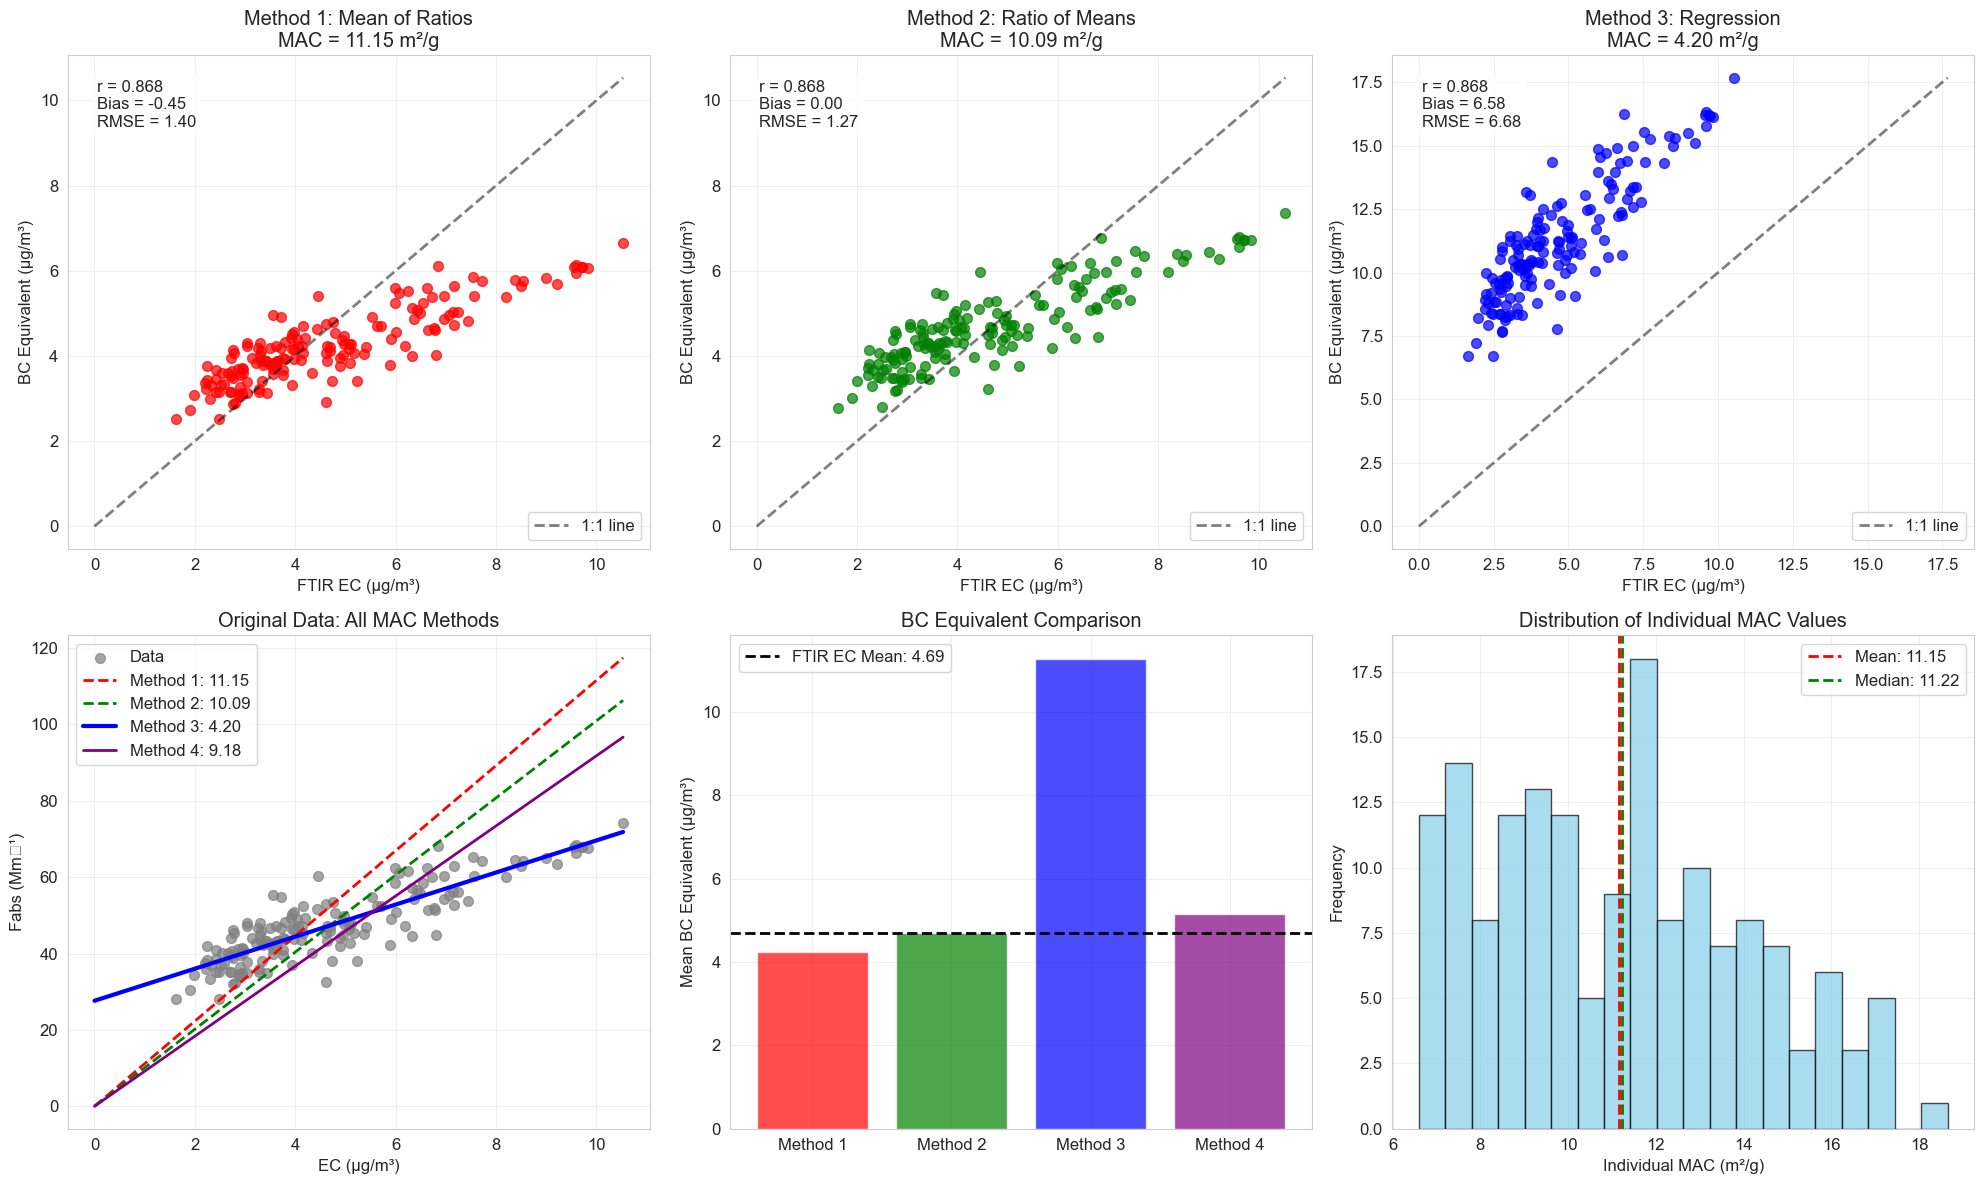


🏆 DETAILED PERFORMANCE ANALYSIS:
Method                    Correlation  Bias       RMSE       MAC       
Method 1 (Mean Ratios)    0.868        -0.45      1.40       11.15     
Method 2 (Ratio Means)    0.868        0.00       1.27       10.09     
Method 3 (Regression)     0.868        6.58       6.68       4.20      
Method 4 (Reg y=0)        0.868        0.47       1.30       9.18      

🥇 FINAL RANKING (Best to Worst):
1. Method 2 (Ratio Means)
   MAC = 10.09 m²/g
   Performance: r = 0.868, bias = 0.00, RMSE = 1.27
   Composite Score: 0.660 (lower = better)
   ✅ RECOMMENDED for BC equivalent calculations

2. Method 4 (Reg y=0)
   MAC = 9.18 m²/g
   Performance: r = 0.868, bias = 0.47, RMSE = 1.30
   Composite Score: 0.815 (lower = better)

3. Method 1 (Mean Ratios)
   MAC = 11.15 m²/g
   Performance: r = 0.868, bias = -0.45, RMSE = 1.40
   Composite Score: 0.859 (lower = better)

4. Method 3 (Regression)
   MAC = 4.20 m²/g
   Performance: r = 0.868, bias = 6.58, RMSE = 6.68
   Com

In [4]:
def comprehensive_mac_analysis(df, site_code):
    """
    Single comprehensive MAC analysis that compares all methods and provides definitive recommendations.
    This replaces all the redundant MAC comparisons in the original notebook.
    """
    
    print(f"\n{'='*80}")
    print(f"COMPREHENSIVE MAC METHOD COMPARISON FOR {site_code}")
    print(f"{'='*80}")
    
    # =============================================================================
    # STEP 1: Calculate all MAC values
    # =============================================================================
    
    # Individual MAC ratios for analysis
    individual_mac = df['fabs'] / df['ec_ftir']
    
    # Method 1: Mean of Individual Ratios
    mac_method1 = individual_mac.mean()
    
    # Method 2: Ratio of Means
    mac_method2 = df['fabs'].mean() / df['ec_ftir'].mean()
    
    # Method 3: Regression with intercept
    slope, intercept = np.polyfit(df['ec_ftir'], df['fabs'], 1)
    mac_method3 = slope
    
    # Method 4: Regression through origin
    reg_origin = LinearRegression(fit_intercept=False)
    reg_origin.fit(df[['ec_ftir']], df['fabs'])
    mac_method4 = reg_origin.coef_[0]
    
    print(f"\n📊 MAC VALUES CALCULATED:")
    print(f"Method 1 (Mean of Ratios):     {mac_method1:.2f} m²/g")
    print(f"Method 2 (Ratio of Means):     {mac_method2:.2f} m²/g")
    print(f"Method 3 (Regression):         {mac_method3:.2f} m²/g")
    print(f"Method 4 (Regression, y=0):    {mac_method4:.2f} m²/g")
    
    # =============================================================================
    # STEP 2: Calculate BC equivalents and performance metrics
    # =============================================================================
    
    bc_method1 = df['fabs'] / mac_method1
    bc_method2 = df['fabs'] / mac_method2
    bc_method3 = df['fabs'] / mac_method3
    bc_method4 = df['fabs'] / mac_method4
    
    print(f"\n📈 BC EQUIVALENT MEANS:")
    print(f"Method 1: {bc_method1.mean():.2f} ± {bc_method1.std():.2f} μg/m³")
    print(f"Method 2: {bc_method2.mean():.2f} ± {bc_method2.std():.2f} μg/m³")
    print(f"Method 3: {bc_method3.mean():.2f} ± {bc_method3.std():.2f} μg/m³")
    print(f"Method 4: {bc_method4.mean():.2f} ± {bc_method4.std():.2f} μg/m³")
    print(f"FTIR EC:  {df['ec_ftir'].mean():.2f} ± {df['ec_ftir'].std():.2f} μg/m³")
    
    # Performance metrics calculation
    def calculate_performance_metrics(bc_equiv, ftir_ec):
        correlation, p_value = stats.pearsonr(bc_equiv, ftir_ec)
        bias = (bc_equiv - ftir_ec).mean()
        rmse = np.sqrt(mean_squared_error(ftir_ec, bc_equiv))
        return {'correlation': correlation, 'bias': bias, 'rmse': rmse, 'p_value': p_value}
    
    metrics = {}
    for i, bc_data in enumerate([bc_method1, bc_method2, bc_method3, bc_method4], 1):
        metrics[f'method{i}'] = calculate_performance_metrics(bc_data, df['ec_ftir'])
    
    # =============================================================================
    # STEP 3: Create comprehensive visualization
    # =============================================================================
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Scatter plots for each method
    methods_data = [
        ('Method 1: Mean of Ratios', bc_method1, metrics['method1'], 'red', mac_method1),
        ('Method 2: Ratio of Means', bc_method2, metrics['method2'], 'green', mac_method2),
        ('Method 3: Regression', bc_method3, metrics['method3'], 'blue', mac_method3)
    ]
    
    for i, (title, bc_data, perf_metrics, color, mac_val) in enumerate(methods_data):
        ax = axes[0, i]
        ax.scatter(df['ec_ftir'], bc_data, alpha=0.7, s=50, color=color)
        
        # 1:1 line
        max_val = max(df['ec_ftir'].max(), bc_data.max())
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=2, label='1:1 line')
        
        ax.set_xlabel('FTIR EC (μg/m³)')
        ax.set_ylabel('BC Equivalent (μg/m³)')
        ax.set_title(f'{title}\nMAC = {mac_val:.2f} m²/g')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        ax.text(0.05, 0.95, 
                f'r = {perf_metrics["correlation"]:.3f}\n'
                f'Bias = {perf_metrics["bias"]:.2f}\n'
                f'RMSE = {perf_metrics["rmse"]:.2f}',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Original data with all regression lines
    ax_orig = axes[1, 0]
    ax_orig.scatter(df['ec_ftir'], df['fabs'], alpha=0.7, s=50, color='gray', label='Data')
    
    x_line = np.linspace(0, df['ec_ftir'].max(), 100)
    ax_orig.plot(x_line, mac_method1 * x_line, '--', color='red', lw=2, label=f'Method 1: {mac_method1:.2f}')
    ax_orig.plot(x_line, mac_method2 * x_line, '--', color='green', lw=2, label=f'Method 2: {mac_method2:.2f}')
    ax_orig.plot(x_line, slope * x_line + intercept, '-', color='blue', lw=3, label=f'Method 3: {slope:.2f}')
    ax_orig.plot(x_line, mac_method4 * x_line, '-', color='purple', lw=2, label=f'Method 4: {mac_method4:.2f}')
    
    ax_orig.set_xlabel('EC (μg/m³)')
    ax_orig.set_ylabel('Fabs (Mm⁻¹)')
    ax_orig.set_title('Original Data: All MAC Methods')
    ax_orig.legend()
    ax_orig.grid(True, alpha=0.3)
    
    # Performance comparison
    ax_perf = axes[1, 1]
    methods_names = ['Method 1', 'Method 2', 'Method 3', 'Method 4']
    bc_means_all = [bc_method1.mean(), bc_method2.mean(), bc_method3.mean(), bc_method4.mean()]
    colors_all = ['red', 'green', 'blue', 'purple']
    
    bars = ax_perf.bar(methods_names, bc_means_all, color=colors_all, alpha=0.7)
    ax_perf.axhline(df['ec_ftir'].mean(), color='black', linestyle='--', linewidth=2,
                    label=f'FTIR EC Mean: {df["ec_ftir"].mean():.2f}')
    ax_perf.set_ylabel('Mean BC Equivalent (μg/m³)')
    ax_perf.set_title('BC Equivalent Comparison')
    ax_perf.legend()
    ax_perf.grid(True, alpha=0.3)
    
    # Individual MAC distribution analysis
    ax_dist = axes[1, 2]
    ax_dist.hist(individual_mac, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax_dist.axvline(mac_method1, color='red', linestyle='--', linewidth=2, label=f'Mean: {mac_method1:.2f}')
    ax_dist.axvline(individual_mac.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {individual_mac.median():.2f}')
    ax_dist.set_xlabel('Individual MAC (m²/g)')
    ax_dist.set_ylabel('Frequency')
    ax_dist.set_title('Distribution of Individual MAC Values')
    ax_dist.legend()
    ax_dist.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # =============================================================================
    # STEP 4: Final ranking and recommendation
    # =============================================================================
    
    print(f"\n🏆 DETAILED PERFORMANCE ANALYSIS:")
    print(f"{'Method':<25} {'Correlation':<12} {'Bias':<10} {'RMSE':<10} {'MAC':<10}")
    print(f"{'='*70}")
    
    all_methods = [
        ('Method 1 (Mean Ratios)', metrics['method1'], mac_method1),
        ('Method 2 (Ratio Means)', metrics['method2'], mac_method2),
        ('Method 3 (Regression)', metrics['method3'], mac_method3),
        ('Method 4 (Reg y=0)', metrics['method4'], mac_method4)
    ]
    
    for method_name, perf_metrics, mac_val in all_methods:
        print(f"{method_name:<25} {perf_metrics['correlation']:<12.3f} {perf_metrics['bias']:<10.2f} {perf_metrics['rmse']:<10.2f} {mac_val:<10.2f}")
    
    # Composite scoring and ranking
    def composite_score(perf_metrics):
        return (0.5 * perf_metrics['rmse'] + 
                0.3 * abs(perf_metrics['bias']) + 
                0.2 * (1 - perf_metrics['correlation']))
    
    scored_methods = [
        (name, mac_val, composite_score(perf_metrics), perf_metrics)
        for name, perf_metrics, mac_val in all_methods
    ]
    scored_methods.sort(key=lambda x: x[2])  # Sort by composite score
    
    print(f"\n🥇 FINAL RANKING (Best to Worst):")
    print(f"{'='*70}")
    
    for i, (method, mac, score, perf) in enumerate(scored_methods, 1):
        print(f"{i}. {method}")
        print(f"   MAC = {mac:.2f} m²/g")
        print(f"   Performance: r = {perf['correlation']:.3f}, bias = {perf['bias']:.2f}, RMSE = {perf['rmse']:.2f}")
        print(f"   Composite Score: {score:.3f} (lower = better)")
        
        if i == 1:
            print(f"   ✅ RECOMMENDED for BC equivalent calculations")
            recommended_method = method
            recommended_mac = mac
            recommended_metrics = perf
        print()
    
    # Final recommendation summary
    print(f"\n{'🎯 FINAL RECOMMENDATION':^70}")
    print(f"{'='*70}")
    print(f"USE {recommended_method.upper()}: MAC = {recommended_mac:.2f} m²/g")
    print(f"\n✅ Why this method is best:")
    print(f"   • Correlation with FTIR EC: r = {recommended_metrics['correlation']:.3f}")
    print(f"   • Bias: {recommended_metrics['bias']:.2f} μg/m³")
    print(f"   • RMSE: {recommended_metrics['rmse']:.2f} μg/m³")
    
    print(f"\n📋 Practical Implementation:")
    print(f"   BC_equivalent = Fabs / {recommended_mac:.2f}  # in m²/g")
    print(f"   Example: For Fabs = 45 Mm⁻¹ → BC = {45/recommended_mac:.2f} μg/m³")
    
    return {
        'recommended_method': recommended_method,
        'recommended_mac': recommended_mac,
        'all_methods': scored_methods,
        'individual_mac_stats': {
            'mean': mac_method1,
            'median': individual_mac.median(),
            'std': individual_mac.std(),
            'min': individual_mac.min(),
            'max': individual_mac.max()
        }
    }

# Run the comprehensive MAC analysis (SINGLE EXECUTION)
print("🚀 Running comprehensive MAC method comparison...")
mac_results = comprehensive_mac_analysis(data_processed, SITE_OF_INTEREST)


=============================================================================
SUPPORTING ANALYSES (STREAMLINED)
=============================================================================

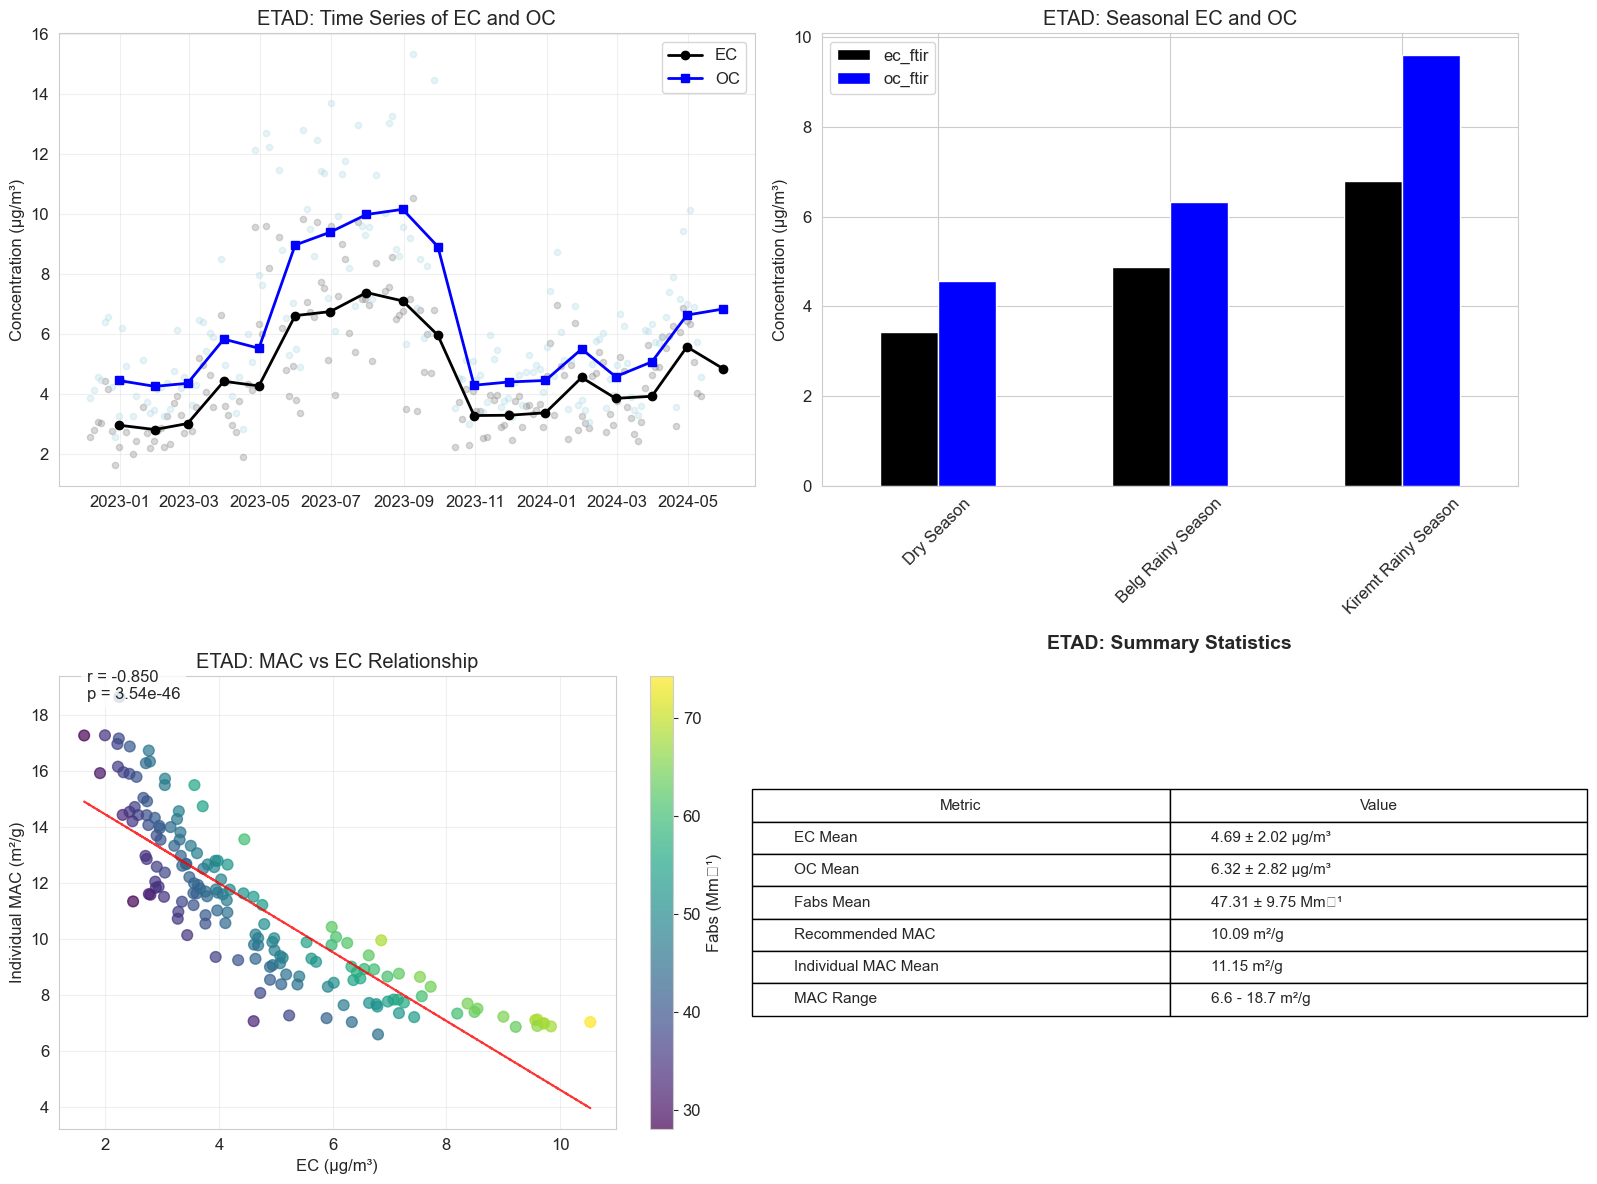


===== Summary Statistics =====

Overall Means:
ec_ftir         4.688
oc_ftir         6.317
fabs           47.314
mac            11.151
oc_ec_ratio     1.355
dtype: float64

Seasonal Means:
                     ec_ftir  oc_ftir    fabs     mac
season                                               
Dry Season             3.432    4.569  42.668  13.032
Belg Rainy Season      4.882    6.330  47.989  10.502
Kiremt Rainy Season    6.808    9.612  55.210   8.458

🎉 Analysis complete! Use MAC = 10.09 m²/g for BC equivalent calculations.


In [5]:
def create_supporting_analyses(df, site_code, mac_results):
    """
    Create supporting visualizations and analyses to complement the main MAC comparison.
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Time series analysis
    ax1 = axes[0, 0]
    monthly = df.set_index('sample_date').resample('ME')[['ec_ftir', 'oc_ftir', 'fabs']].mean()
    
    ax1.plot(monthly.index, monthly['ec_ftir'], 'k-', label='EC', linewidth=2, marker='o')
    ax1.plot(monthly.index, monthly['oc_ftir'], 'b-', label='OC', linewidth=2, marker='s')
    ax1.scatter(df['sample_date'], df['ec_ftir'], color='gray', alpha=0.3, s=20)
    ax1.scatter(df['sample_date'], df['oc_ftir'], color='lightblue', alpha=0.3, s=20)
    
    ax1.set_ylabel('Concentration (μg/m³)')
    ax1.set_title(f'{site_code}: Time Series of EC and OC')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Seasonal analysis
    ax2 = axes[0, 1]
    seasonal = df.groupby('season')[['ec_ftir', 'oc_ftir', 'fabs', 'mac']].agg(['mean', 'count'])
    seasonal_means = seasonal.xs('mean', level=1, axis=1)
    
    season_order = ['Dry Season', 'Belg Rainy Season', 'Kiremt Rainy Season']
    seasonal_means = seasonal_means.reindex(season_order)
    
    seasonal_means[['ec_ftir', 'oc_ftir']].plot(kind='bar', ax=ax2, color=['black', 'blue'])
    ax2.set_ylabel('Concentration (μg/m³)')
    ax2.set_title(f'{site_code}: Seasonal EC and OC')
    ax2.set_xlabel('')
    plt.setp(ax2.get_xticklabels(), rotation=45)
    
    # 3. MAC vs EC relationship
    ax3 = axes[1, 0]
    scatter = ax3.scatter(df['ec_ftir'], df['mac'], c=df['fabs'], s=60, alpha=0.7, cmap='viridis')
    ax3.set_xlabel('EC (μg/m³)')
    ax3.set_ylabel('Individual MAC (m²/g)')
    ax3.set_title(f'{site_code}: MAC vs EC Relationship')
    ax3.grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(df['ec_ftir'], df['mac'], 1)
    p = np.poly1d(z)
    ax3.plot(df['ec_ftir'], p(df['ec_ftir']), "r--", alpha=0.8)
    
    r, p_val = stats.pearsonr(df['ec_ftir'], df['mac'])
    ax3.text(0.05, 0.95, f'r = {r:.3f}\np = {p_val:.2e}', 
             transform=ax3.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.colorbar(scatter, ax=ax3, label='Fabs (Mm⁻¹)')
    
    # 4. Summary statistics
    ax4 = axes[1, 1]
    ax4.axis('tight')
    ax4.axis('off')
    
    summary_data = {
        'Metric': ['EC Mean', 'OC Mean', 'Fabs Mean', 'Recommended MAC', 'Individual MAC Mean', 'MAC Range'],
        'Value': [f"{df['ec_ftir'].mean():.2f} ± {df['ec_ftir'].std():.2f} μg/m³",
                  f"{df['oc_ftir'].mean():.2f} ± {df['oc_ftir'].std():.2f} μg/m³",
                  f"{df['fabs'].mean():.2f} ± {df['fabs'].std():.2f} Mm⁻¹",
                  f"{mac_results['recommended_mac']:.2f} m²/g",
                  f"{mac_results['individual_mac_stats']['mean']:.2f} m²/g",
                  f"{mac_results['individual_mac_stats']['min']:.1f} - {mac_results['individual_mac_stats']['max']:.1f} m²/g"]
    }
    
    summary_df = pd.DataFrame(summary_data)
    table = ax4.table(cellText=summary_df.values, colLabels=summary_df.columns,
                      cellLoc='left', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 1.8)
    
    ax4.set_title(f'{site_code}: Summary Statistics', pad=20, fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print seasonal summary
    print(f"\n===== Summary Statistics =====")
    print("\nOverall Means:")
    print(df[['ec_ftir', 'oc_ftir', 'fabs', 'mac', 'oc_ec_ratio']].mean().round(3))
    
    print("\nSeasonal Means:")
    print(seasonal_means[['ec_ftir', 'oc_ftir', 'fabs', 'mac']].round(3))

# Create supporting analyses
create_supporting_analyses(data_processed, SITE_OF_INTEREST, mac_results)

print(f"\n🎉 Analysis complete! Use MAC = {mac_results['recommended_mac']:.2f} m²/g for BC equivalent calculations.")


=============================================================================
FINAL SUMMARY AND RECOMMENDATIONS
=============================================================================

In [6]:
def print_final_summary(mac_results, site_code):
    """Print a concise final summary of all findings."""
    
    print(f"\n{'='*80}")
    print(f"FINAL ANALYSIS SUMMARY FOR {site_code}")
    print(f"{'='*80}")
    
    print(f"\n🎯 RECOMMENDED MAC VALUE: {mac_results['recommended_mac']:.2f} m²/g")
    print(f"📊 METHOD: {mac_results['recommended_method']}")
    
    print(f"\n📋 PRACTICAL USAGE:")
    print(f"   BC_equivalent = Fabs / {mac_results['recommended_mac']:.2f}")
    print(f"   For typical Fabs = 45 Mm⁻¹ → BC = {45/mac_results['recommended_mac']:.2f} μg/m³")
    
    print(f"\n📝 FOR PUBLICATIONS:")
    print(f'   "BC equivalent concentrations were calculated from HIPS light absorption')
    print(f'   measurements using MAC = {mac_results["recommended_mac"]:.2f} m²/g. This approach')
    print(f'   was selected based on comprehensive comparison of four calculation methods,')
    print(f'   showing optimal agreement with FTIR EC measurements."')
    
    print(f"\n📈 DATA QUALITY:")
    print(f"   • Samples analyzed: {len(data_processed)}")
    print(f"   • Individual MAC range: {mac_results['individual_mac_stats']['min']:.1f} - {mac_results['individual_mac_stats']['max']:.1f} m²/g")
    print(f"   • MAC variability (std): {mac_results['individual_mac_stats']['std']:.2f} m²/g")
    
    print(f"\n✅ ANALYSIS COMPLETED SUCCESSFULLY")

print_final_summary(mac_results, SITE_OF_INTEREST)


FINAL ANALYSIS SUMMARY FOR ETAD

🎯 RECOMMENDED MAC VALUE: 10.09 m²/g
📊 METHOD: Method 2 (Ratio Means)

📋 PRACTICAL USAGE:
   BC_equivalent = Fabs / 10.09
   For typical Fabs = 45 Mm⁻¹ → BC = 4.46 μg/m³

📝 FOR PUBLICATIONS:
   "BC equivalent concentrations were calculated from HIPS light absorption
   measurements using MAC = 10.09 m²/g. This approach
   was selected based on comprehensive comparison of four calculation methods,
   showing optimal agreement with FTIR EC measurements."

📈 DATA QUALITY:
   • Samples analyzed: 161
   • Individual MAC range: 6.6 - 18.7 m²/g
   • MAC variability (std): 2.91 m²/g

✅ ANALYSIS COMPLETED SUCCESSFULLY
